<a href="https://colab.research.google.com/github/amr-elbana/AI-driven-post-harvest-sorting-system/blob/main/classification-Models/Augmented_Dataset_Models/modified_orange_classification_efficientnetB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras,os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input,EfficientNetB2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# **DataSet**

In [ ]:
# Define paths and constants
train_dir = "/content/drive/MyDrive/final project/Dataset/original_dataset/train-2"
test_dir = "/content/drive/MyDrive/final project/Dataset/original_dataset/test"
val_dir = "/content/drive/MyDrive/final project/Dataset/original_dataset/validation"
batch_size = 32
target_size = (224, 224)
epochs = 50

In [ ]:

# Create an ImageDataGenerator with EfficientNetB2 preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNetB2-specific preprocessing
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Randomly apply shearing transformations
    zoom_range=0.2,         # Randomly zoom in or out on images
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill in missing pixels using the nearest neighbor
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNetB2-specific preprocessing
)

# Flow training data from the directory and apply preprocessing and augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,      # Resize images to EfficientNetB2 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    seed=42,                      # Set seed for reproducibility
    shuffle=True                  # Shuffle the data to improve training
)

# Flow validation data from the directory and apply preprocessing (no augmentation for validation)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,      # Resize images to EfficientNetB2 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    shuffle=False                 # No need to shuffle validation data
)

# ... (rest of the code remains the same)

# Check the number of samples in each generator
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Validation batches per epoch: {len(validation_generator)}")

Found 6368 images belonging to 2 classes.
Found 297 images belonging to 2 classes.
Training samples: 6368
Validation samples: 297
Training batches per epoch: 199
Validation batches per epoch: 10


In [ ]:
# Create an ImageDataGenerator for EfficientNetB2 preprocessing (no augmentation for the test set)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # EfficientNetB2-specific preprocessing
)

# Flow data from the test directory and apply preprocessing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # efficientnetB2 input size
    batch_size=batch_size,
    class_mode='binary',     # Binary classification for the test set
    shuffle=False            # Do not shuffle test data to keep results consistent
)

# Check the number of samples in the test set
print(f"Test samples: {test_generator.samples}")
print(f"Test batches: {len(test_generator)}")

Found 373 images belonging to 2 classes.
Test samples: 373
Test batches: 12


# **Model Architecture**

In [ ]:
"""EfficientNetB2 is a functional model, and its layers are interdependent.
Adding the entire model instead of individual layers ensures the integrity of its structure,
 preventing errors during training.
 Using GlobalAveragePooling2D further optimizes the architecture for the task."""

import os
from tensorflow.keras.layers import GlobalAveragePooling2D
def create_model():
    # Load EfficientNetB2 model with pretrained weights, excluding the top (fully connected) layers
    efficientnet_base = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of EfficientNetB2 to retain the pre-trained weights
    for layer in efficientnet_base.layers[:-20]:
        layer.trainable = False

    # Build the model
    model = Sequential([
        efficientnet_base,  # Add the entire base model
        GlobalAveragePooling2D(),  # Replace Flatten with GAP for efficiency
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Regularization
        BatchNormalization(),
        Dropout(0.7),  # Prevent overfitting
        Dense(64, activation='relu',kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(1, activation='sigmoid')  # For binary classification
    ])

    # Compile the model
    optimizer = SGD(learning_rate=0.0001, momentum=0.9)  # Lower learning rate
    model.compile(optimizer = optimizer,loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Ensure the directory for checkpoints exists
model_dir = "/content/drive/MyDrive/final project/modified augmented model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define the model
model = create_model()


# **Training**

In [ ]:
# Define callbacks
checkpoint_path = "/content/drive/MyDrive/final project/modified augmented model/EfficientNetB2_{epoch:02d}-{val_accuracy:0.2f}.keras"
model_dir = "/content/drive/MyDrive/final project/modified augmented model"
# ModelCheckpoint: Save best model based on val_accuracy
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping_monitor = EarlyStopping(monitor='val_loss',patience = 3,restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
# Train the model
History = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping_monitor,lr_scheduler]
)
model.save('/content/drive/MyDrive/final project/modified augmented model/EfficientNetB2_best_model.h5')

Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.5841 - loss: 4.1391
Epoch 1: val_accuracy improved from -inf to 0.82828, saving model to /content/drive/MyDrive/final project/modified augmented model/EfficientNetB2_01-0.83.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 232s 973ms/step - accuracy: 0.5844 - loss: 4.1384 - val_accuracy: 0.8283 - val_loss: 3.6196 - learning_rate: 1.0000e-04
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.7221 - loss: 3.7868
Epoch 2: val_accuracy improved from 0.82828 to 0.86532, saving model to /content/drive/MyDrive/final project/modified augmented model/EfficientNetB2_02-0.87.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 179s 871ms/step - accuracy: 0.7222 - loss: 3.7866 - val_accuracy: 0.8653 - val_loss: 3.4587 - learning_rate: 1.0000e-04
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.7753 - loss: 3.6646
Epoch 3: val_accuracy improved from 0.86532 to 0.88215, saving model to /content/drive/MyDrive/final project/modifi

# **History Plotting**

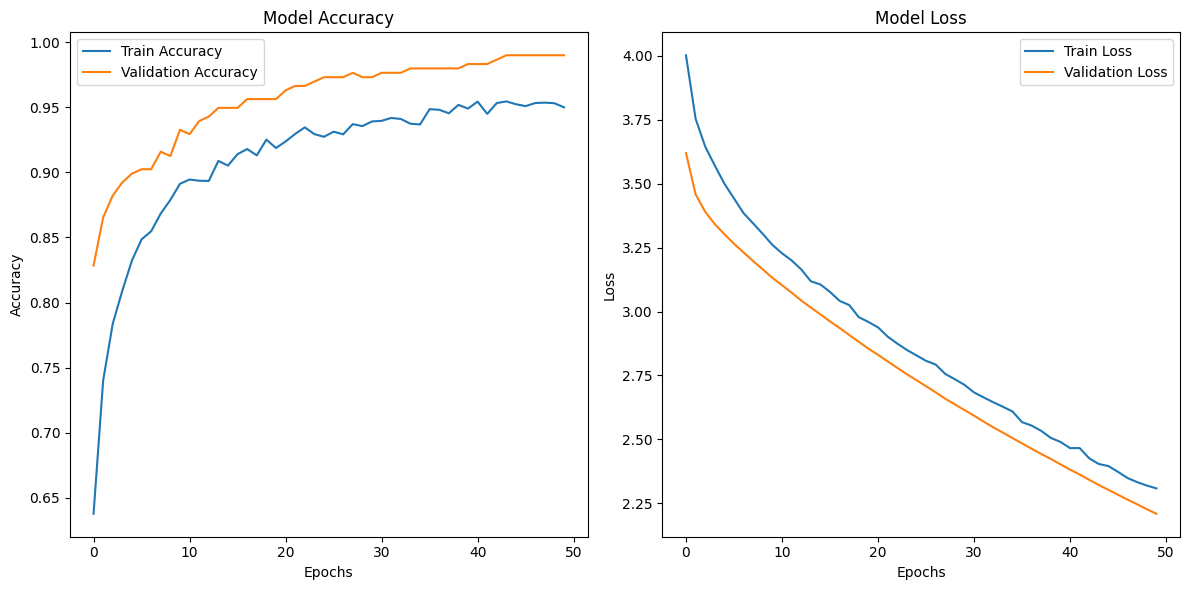

In [ ]:
import matplotlib.pyplot as plt

# Extract the training history
history = History.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
final_train_acc = History.history['accuracy'][-1]
final_val_acc = History.history['val_accuracy'][-1]
final_train_loss = History.history['loss'][-1]
final_val_loss = History.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.9499
Final Validation Accuracy: 0.9899
Final Training Loss: 2.3080
Final Validation Loss: 2.2088


In [ ]:
if 'lr' in History.history:
    plt.plot(History.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

In [ ]:
print(f"Training stopped at epoch: {len(History.history['loss'])}")


Training stopped at epoch: 50


# **History Saving**

In [ ]:
import json

# Save history to a JSON file on Google Drive
with open("/content/drive/MyDrive/final project/modified augmented model/training_history.json", "w") as f:
    json.dump(History.history, f)

# Load the history later
with open("/content/drive/MyDrive/final project/modified augmented model/training_history.json", "r") as f:
    loaded_history = json.load(f)
    print(loaded_history)

{'accuracy': [0.6377198696136475, 0.7401067614555359, 0.7837625741958618, 0.809202253818512, 0.8322864174842834, 0.8484610319137573, 0.8547424674034119, 0.8684045076370239, 0.8787688612937927, 0.8911746144294739, 0.8944723606109619, 0.8935301303863525, 0.8933731317520142, 0.9087625741958618, 0.9051507711410522, 0.9139447212219238, 0.9178705811500549, 0.9130024909973145, 0.9250942468643188, 0.9186557531356812, 0.9236809015274048, 0.9294912219047546, 0.9345163106918335, 0.9293341636657715, 0.9272927045822144, 0.9312185645103455, 0.9291771650314331, 0.9370288848876953, 0.9354585409164429, 0.9390703439712524, 0.9395414590835571, 0.9417399764060974, 0.9409547448158264, 0.9373429417610168, 0.9367148280143738, 0.9484924674034119, 0.9480213522911072, 0.945351779460907, 0.9517902135848999, 0.9489635825157166, 0.9543027877807617, 0.9448806643486023, 0.9532034993171692, 0.9544597864151001, 0.9522613286972046, 0.9508479833602905, 0.9532034993171692, 0.9535176157951355, 0.9530465006828308, 0.949905

# **Model Evaluation Using Test Data**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
import tensorflow as tf
checkpoint_path = '/content/drive/MyDrive/final project/modified augmented model/EfficientNetB2_best_model.h5'
model = tf.keras.models.load_model(checkpoint_path)

test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels
predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()

# Get the true labels
true_labels = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Healthy', 'Rotten'])
print("\nClassification Report:\n", class_report)

# Accuracy Score
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nAccuracy:", accuracy)

# F1 Score
f1 = f1_score(true_labels, predicted_labels)
print("\nF1 Score:", f1)


12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step
Confusion Matrix:
 [[184   1]
 [  4 184]]

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.98      0.99      0.99       185
      Rotten       0.99      0.98      0.99       188

    accuracy                           0.99       373
   macro avg       0.99      0.99      0.99       373
weighted avg       0.99      0.99      0.99       373


Accuracy: 0.9865951742627346

F1 Score: 0.9865951742627346


In [ ]:
# Define where to save everything
results_save_path = "/content/drive/MyDrive/final project/modified augmented model/EfficientNetB2_results.txt"
conf_matrix_save_path = "/content/drive/MyDrive/final project/modified augmented model/EfficientNetB2_confusion_matrix.png"
with open(results_save_path, "w") as file:
    file.write(f"Accuracy: {accuracy:.4f}\n")
    file.write(f"F1 Score: {f1:.4f}\n")
    file.write(f"classification Report:\n {class_report}\n")
    file.write(f"Confusion Matrix:\n{conf_matrix}\n")

print(f"Results saved to {results_save_path}")

Results saved to /content/drive/MyDrive/final project/modified augmented model/EfficientNetB2_results.txt


In [ ]:
import matplotlib.pyplot as plt  # Import the plotting library and assign it to the alias 'plt'
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Rotten"], yticklabels=["Healthy", "Rotten"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Save confusion matrix as an image
plt.savefig(conf_matrix_save_path)
print(f"Confusion matrix saved to {conf_matrix_save_path}")
from IPython.display import Image
Image(filename=conf_matrix_save_path)
plt.close()  # Close the plot to free up memory

Confusion matrix saved to /content/drive/MyDrive/final project/modified augmented model/EfficientNetB2_confusion_matrix.png
